# I. Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense,LeakyReLU
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import backend as K
import time

# II. Giới thiệu các hàm kích hoạt

In [42]:
x = np.arange(-5, 5, 0.01)

In [43]:
def plot(func,dfunc, yaxis=(-1.4, 1.4)):
    plt.ylim(yaxis)
    plt.locator_params(nbins=5)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.axhline(lw=1, c='black')
    plt.axvline(lw=1, c='black')
    plt.grid(alpha=0.4, ls='-.')
    plt.box(on=None)
    plt.plot(x, y, c='r', lw=3, label ='f(x)')
    plt.plot(x, dy, c='b', lw=3, label ='df(x)')

## 1. RELU
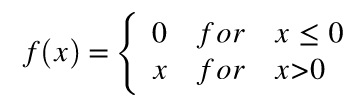

In [44]:
def ReLU(x):
  return np.where(x >= 0, x, 0)
  
def graReLU(x):
  return np.where(x >= 0, 1, 0)

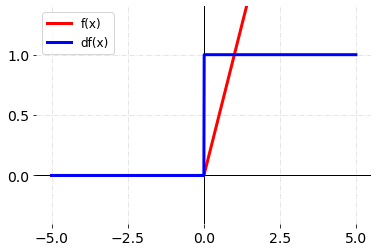

In [45]:
y = [ReLU(i) for i in x]
dy = [graReLU(i) for i in x]
plot(y,dy, yaxis=(-0.4, 1.4))
plt.legend(fontsize = 12, loc='upper left')
plt.show()

## 2. LeakyRELU
 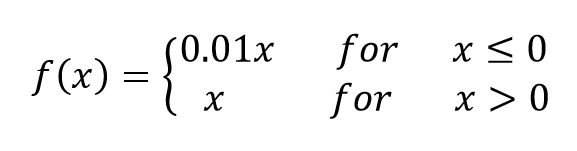

In [46]:
def leakyReLU(x):
    return np.where(x >= 0, x, 0.01 * x)
  
def gradLeakyReLU(x):
    return np.where(x >= 0, 1, 0.01)

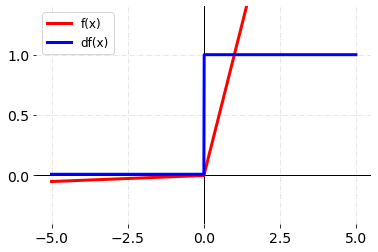

In [47]:
y = [leakyReLU(i) for i in x]
dy = [gradLeakyReLU(i) for i in x]
plot(y,dy, yaxis=(-0.4, 1.4))
plt.legend(fontsize = 12, loc='upper left')
plt.show()

## 3. Sigmoid
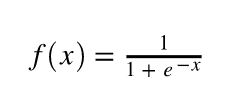

In [48]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def gradSigmoid(s):
  return s * (1.0 - s)

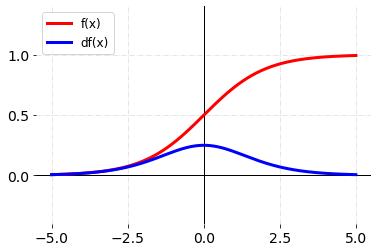

In [49]:
y = [sigmoid(i) for i in x]
dy = [gradSigmoid(sigmoid(i)) for i in x]
plot(y,dy, yaxis=(-0.4, 1.4))
plt.legend(fontsize = 12, loc='upper left')
plt.show()

# III. Đánh giá độ hiệu quả trên bộ dữ liệu MNIST

##1. MNIST dataset

In [50]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

num_classes = len(np.unique(y))
print(num_classes)

10


In [51]:
print("Number of samples for each class")
x_value=list(range(10))
y_value=np.zeros(10)
for i in y:
  y_value[i]+=1
print(y_value)

Number of samples for each class
[6903. 7877. 6990. 7141. 6824. 6313. 6876. 7293. 6825. 6958.]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


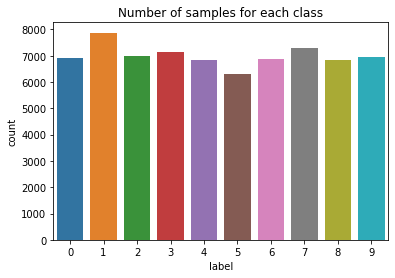

In [52]:
ax = sns.barplot(x_value, y_value)
ax.set(xlabel='label', ylabel='count', title='Number of samples for each class')
plt.show()

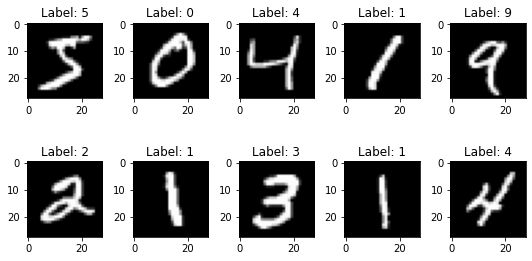

In [53]:
# plot 10 ảnh đầu tiên trong MNIST
num = 10
images = X[:num]
labels = y[:num]

fig, axes = plt.subplots(2, 5, figsize=(1.5*5,2*2))
for i in range(num):
    ax = axes[i//5, i%5]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [54]:
# Chia dữ liệu thành 3 tập train - val - test
train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

num_pixels = 784
X_train = X_train.reshape(X_train.shape[0], num_pixels)/255
X_test = X_test.reshape(X_test.shape[0], num_pixels)/255
X_val = X_val.reshape(X_val.shape[0], num_pixels)/255
y_train = to_categorical(y_train.astype("int"),num_classes)
y_test = to_categorical(y_test,num_classes)
y_val = to_categorical(y_val,num_classes)

print("X_train",X_train.shape)
print("y_train",y_train.shape)
print()
print("X_val",X_val.shape)
print("y_val",y_val.shape)
print()
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (48999, 784)
y_train (48999, 10)

X_val (7000, 784)
y_val (7000, 10)

X_test (14001, 784)
y_test (14001, 10)


##2. Sử dụng thư viện Keras để xây dựng mô hình

###2.1. Các tham số đánh giá độ hiệu quả

In [55]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

###2.2. Mô hình sử dụng hàm **RELU**

In [56]:
model = Sequential()
model.add(Input(X_train.shape[1]))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer = "sgd", loss = 'categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

history = model.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=64,epochs=100)

relu_loss,relu_accuracy,relu_f1,relu_precision,relu_recall = model.evaluate(X_test,y_test)

print()
print("RELU model")
print('loss: ', round(relu_loss, 4))
print('accuracy: ', round(relu_accuracy, 4))
print('f1: ', round(relu_f1, 4))
print('precision: ', round(relu_precision, 4))
print('recall: ', round(relu_recall, 4))

Epoch 1/100
766/766 [==============================] - 3s 3ms/step - loss: 1.0670 - accuracy: 0.7183 - f1: 0.5186 - precision: 0.8258 - recall: 0.4291 - val_loss: 0.4750 - val_accuracy: 0.8787 - val_f1: 0.8628 - val_precision: 0.9412 - val_recall: 0.7978
Epoch 2/100
766/766 [==============================] - 2s 3ms/step - loss: 0.4030 - accuracy: 0.8890 - f1: 0.8844 - precision: 0.9381 - recall: 0.8375 - val_loss: 0.3402 - val_accuracy: 0.9053 - val_f1: 0.9046 - val_precision: 0.9407 - val_recall: 0.8717
Epoch 3/100
766/766 [==============================] - 2s 3ms/step - loss: 0.3239 - accuracy: 0.9092 - f1: 0.9082 - precision: 0.9408 - recall: 0.8784 - val_loss: 0.3007 - val_accuracy: 0.9141 - val_f1: 0.9147 - val_precision: 0.9397 - val_recall: 0.8913
Epoch 4/100
766/766 [==============================] - 2s 3ms/step - loss: 0.2862 - accuracy: 0.9185 - f1: 0.9190 - precision: 0.9442 - recall: 0.8957 - val_loss: 0.2680 - val_accuracy: 0.9253 - val_f1: 0.9273 - val_precision: 0.9476 -

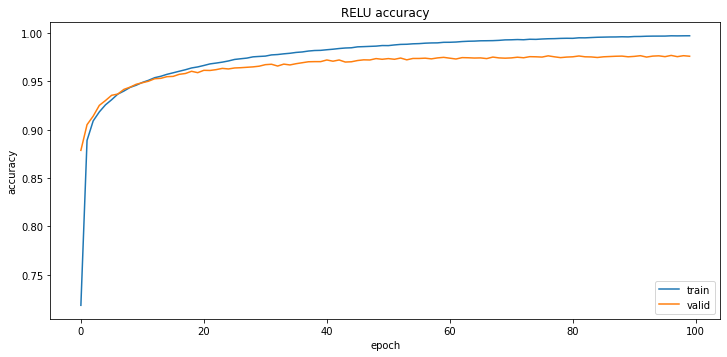

In [57]:
# plotting the metrics
fig = plt.figure(figsize=(12, 12))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RELU accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

###2.3. Mô hình sử dụng hàm **leakyRELU**

In [58]:
model_lrelu = Sequential()
model_lrelu.add(Input(X_train.shape[1]))
model_lrelu.add(Dense(units=128))
model_lrelu.add(LeakyReLU(alpha=0.01))
model_lrelu.add(Dense(units=64))
model_lrelu.add(LeakyReLU(alpha=0.01))
model_lrelu.add(Dense(units=num_classes, activation='softmax'))

model_lrelu.compile(optimizer = "sgd", loss = 'categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

history2 = model_lrelu.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=64,epochs=100)

lrelu_loss,lrelu_accuracy,lrelu_f1,lrelu_precision,lrelu_recall = model_lrelu.evaluate(X_test,y_test)

print()
print("leakyRELU model")
print('loss: ', round(lrelu_loss, 4))
print('accuracy: ', round(lrelu_accuracy, 4))
print('f1: ', round(lrelu_f1, 4))
print('precision: ', round(lrelu_precision, 4))
print('recall: ', round(lrelu_recall, 4))

Epoch 1/100
766/766 [==============================] - 3s 3ms/step - loss: 0.9761 - accuracy: 0.7464 - f1: 0.5616 - precision: 0.8088 - recall: 0.4722 - val_loss: 0.4534 - val_accuracy: 0.8797 - val_f1: 0.8694 - val_precision: 0.9373 - val_recall: 0.8116
Epoch 2/100
766/766 [==============================] - 2s 3ms/step - loss: 0.3975 - accuracy: 0.8906 - f1: 0.8865 - precision: 0.9372 - recall: 0.8420 - val_loss: 0.3379 - val_accuracy: 0.9046 - val_f1: 0.9035 - val_precision: 0.9354 - val_recall: 0.8741
Epoch 3/100
766/766 [==============================] - 2s 3ms/step - loss: 0.3280 - accuracy: 0.9069 - f1: 0.9069 - precision: 0.9380 - recall: 0.8782 - val_loss: 0.3018 - val_accuracy: 0.9164 - val_f1: 0.9153 - val_precision: 0.9408 - val_recall: 0.8916
Epoch 4/100
766/766 [==============================] - 2s 3ms/step - loss: 0.2933 - accuracy: 0.9161 - f1: 0.9167 - precision: 0.9416 - recall: 0.8935 - val_loss: 0.2742 - val_accuracy: 0.9221 - val_f1: 0.9221 - val_precision: 0.9425 -

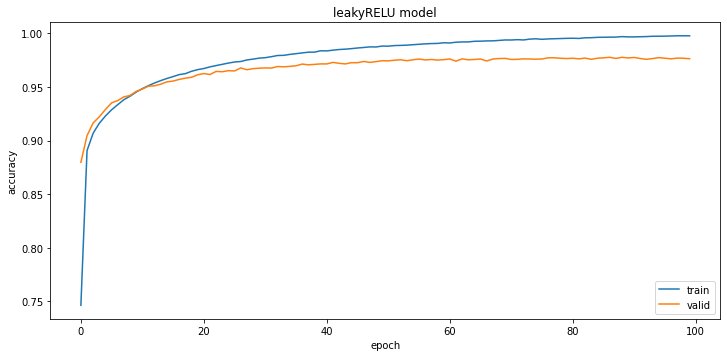

In [59]:
# plotting the metrics
fig = plt.figure(figsize=(12, 12))
plt.subplot(2,1,1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('leakyRELU model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

###2.4. Mô hình sử dụng hàm **Sigmoid**

In [60]:
model_sigmoid = Sequential()
model_sigmoid.add(Input(X_train.shape[1]))
model_sigmoid.add(Dense(units=128, activation='sigmoid'))
model_sigmoid.add(Dense(units=64, activation='sigmoid'))
model_sigmoid.add(Dense(units=num_classes, activation = 'softmax'))

model_sigmoid.compile(optimizer = "sgd", loss = 'categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

history3 = model_sigmoid.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=64,epochs=100)

sigmoid_loss,sigmoid_accuracy,sigmoid_f1,sigmoid_precision,sigmoid_recall = model_sigmoid.evaluate(X_test,y_test)

print()
print("Sigmoid model")
print('loss: ', round(sigmoid_loss, 4))
print('accuracy: ', round(sigmoid_accuracy, 4))
print('f1: ', round(sigmoid_f1, 4))
print('precision: ', round(sigmoid_precision, 4))
print('recall: ', round(sigmoid_recall, 4))

Epoch 1/100
766/766 [==============================] - 3s 3ms/step - loss: 2.2638 - accuracy: 0.2468 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2138 - val_accuracy: 0.3660 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
766/766 [==============================] - 2s 3ms/step - loss: 2.1565 - accuracy: 0.4741 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.0835 - val_accuracy: 0.5647 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
766/766 [==============================] - 2s 3ms/step - loss: 1.9820 - accuracy: 0.6030 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8551 - val_accuracy: 0.6444 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
766/766 [==============================] - 2s 3ms/step - loss: 1.7009 - accuracy: 0.6735 - f1: 0.0141 - precision: 0.2689 - recall: 0.0073 - val_loss: 

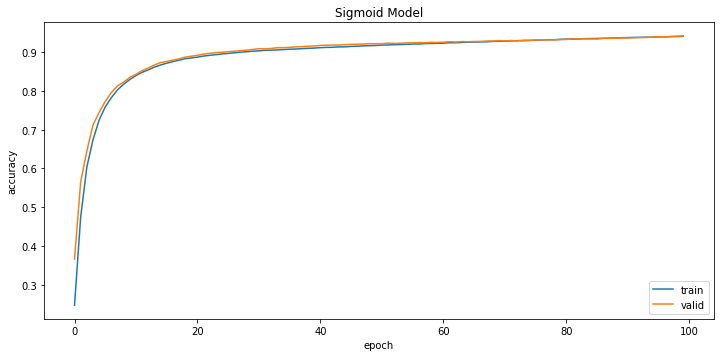

In [61]:
# plotting the metrics
fig = plt.figure(figsize=(12, 12))
plt.subplot(2,1,1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Sigmoid Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

###2.5. Visualizing results

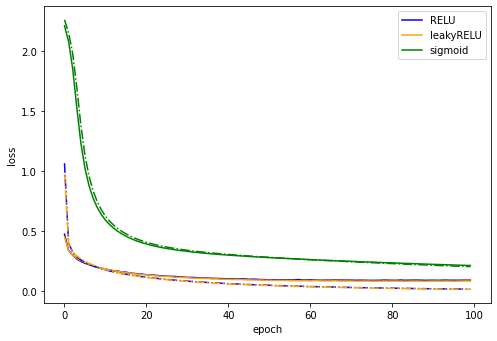

In [62]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(history.history['val_loss'], c='b')
plt.plot(history2.history['val_loss'], c='orange')
plt.plot(history3.history['val_loss'], c='g')
plt.plot(history.history['loss'], ls='-.', c='b')
plt.plot(history2.history['loss'], ls='-.', c='orange')
plt.plot(history3.history['loss'], ls='-.', c='g')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['RELU', 'leakyRELU', 'sigmoid'], loc='upper right')

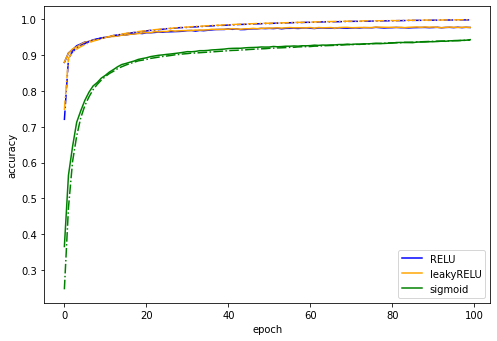

In [63]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(history.history['val_accuracy'], c='b')
plt.plot(history2.history['val_accuracy'], c='orange')
plt.plot(history3.history['val_accuracy'], c='g')
plt.plot(history.history['accuracy'], ls='-.', c='b')
plt.plot(history2.history['accuracy'], ls='-.', c='orange')
plt.plot(history3.history['accuracy'], ls='-.', c='g')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['RELU', 'leakyRELU', 'sigmoid'], loc='lower right')

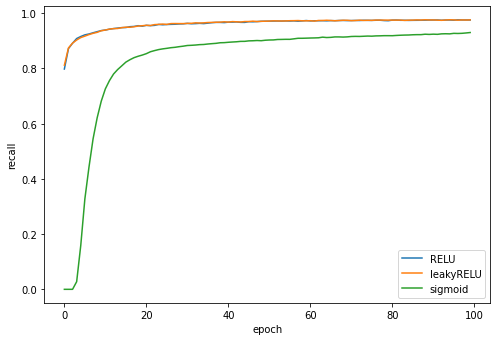

In [64]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(history.history['val_recall'])
plt.plot(history2.history['val_recall'])
plt.plot(history3.history['val_recall'])
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['RELU', 'leakyRELU', 'sigmoid'], loc='lower right')

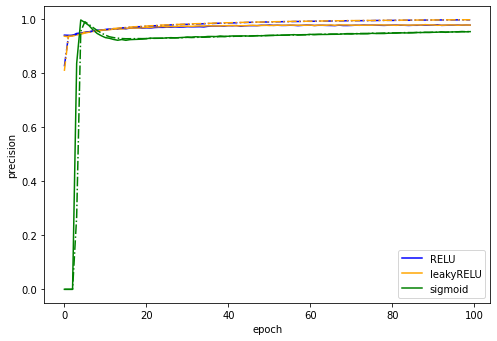

In [65]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(history.history['val_precision'], c='b')
plt.plot(history2.history['val_precision'], c='orange')
plt.plot(history3.history['val_precision'], c='g')
plt.plot(history.history['precision'], ls='-.', c='b')
plt.plot(history2.history['precision'], ls='-.', c='orange')
plt.plot(history3.history['precision'], ls='-.', c='g')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['RELU', 'leakyRELU', 'sigmoid'], loc='lower right')

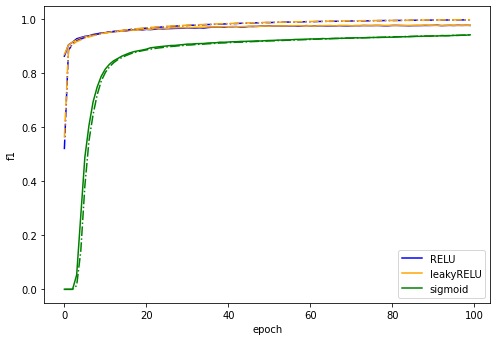

In [66]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(history.history['val_f1'], c='b')
plt.plot(history2.history['val_f1'], c='orange')
plt.plot(history3.history['val_f1'], c='g')
plt.plot(history.history['f1'], ls='-.', c='b')
plt.plot(history2.history['f1'], ls='-.', c='orange')
plt.plot(history3.history['f1'], ls='-.', c='g')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['RELU', 'leakyRELU', 'sigmoid'], loc='lower right')

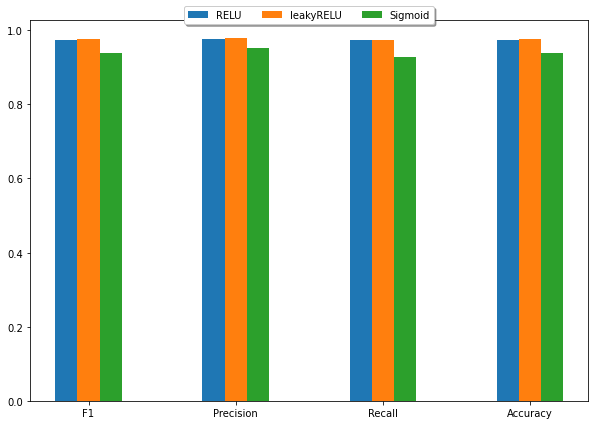

In [67]:
#Trên tập test
N = 4
ind = np.arange(N) 
width = 0.15

score = [[relu_f1, relu_precision, relu_recall, relu_accuracy],
         [lrelu_f1, lrelu_precision, lrelu_recall,lrelu_accuracy],
         [sigmoid_f1, sigmoid_precision, sigmoid_recall, sigmoid_accuracy]]

fig = plt.figure(figsize=(10, 7))
bar1 = plt.bar(ind, score[0], width)
bar2 = plt.bar(ind+width, score[1], width)
bar3 = plt.bar(ind+width*2, score[2], width)

plt.xticks(ind+width,['F1', 'Precision', 'Recall', 'Accuracy'])
plt.legend( (bar1, bar2, bar3), ('RELU', 'leakyRELU', 'Sigmoid'),
           loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

##3. Neural Network from scratch

In [68]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

num_classes = len(np.unique(y))

train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

num_pixels = 784
X_train = X_train.reshape(X_train.shape[0], num_pixels)/255
X_test = X_test.reshape(X_test.shape[0], num_pixels)/255
X_val = X_val.reshape(X_val.shape[0], num_pixels)/255
y_train = to_categorical(y_train.astype("int"),num_classes)
y_test = to_categorical(y_test,num_classes)
y_val = to_categorical(y_val,num_classes)

###3.1. Activation function

In [69]:
class ReLU():
  def __init__(self): pass
  
  def __call__(self, x):
    return self.activation(x)
  
  def activation(self, x):
    return np.where(x >= 0, x, 0)
  
  def gradient(self, x):
    return np.where(x >= 0, 1, 0)

In [70]:
class LeakyReLU():
  def __init__(self): pass
  
  def __call__(self, x):
    return self.activation(x)
  
  def activation(self, x):
    return np.where(x >= 0, x, 0.01 * x)
  
  def gradient(self, x):
    return np.where(x >= 0, 1, 0.01)

In [71]:
class Sigmoid():
  def __init__(self): pass
  
  def __call__(self, x):
    return self.activation(x)
  
  def activation(self, x):
    return 1 / (1 + np.exp(-x))
  
  def gradient(self, x):
    s = self.activation(x)
    return s * (1.0 - s)

In [72]:
class Softmax():
  def __init__(self): pass
  
  def __call__(self, x):
    return self.activation(x)
  
  def activation(self, x):
    e_x = np.exp(x - np.max(x, axis = -1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims = True)
  
  def gradient(self, x):
    p = self.activation(x)
    return p * (1 - p)

###3.2. Loss function

In [73]:
class CrossEntropy():
  def __init__(self): pass

  def loss(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -y*np.log(p) - (1 - y) * np.log(1- p)
  
  def gradient(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -(y/p) + (1 - y) / (1 - p)

###3.3. Layer

In [74]:
class Activation():
  def __init__(self, activation, name="activation"):
    self.activation = activation
    self.gradient = activation.gradient
    self.input = None
    self.output = None
    self.name = name
  
  def forward(self, x):
    self.input = x
    self.output = self.activation(x)
    return self.output
  
  def backward(self, output_error, lr = 0.01):
    return self.gradient(self.input) * output_error
  
  def __call__(self, x):
    return self.forward(x)

In [75]:
class Dense():
  def __init__(self, n_in, n_out, name="dense"):
    limit = 1 / np.sqrt(n_in)
    self.W = np.random.uniform(-limit, limit, (n_in, n_out))
    self.b = np.zeros((1, n_out)) # Biases
    self.input = None
    self.output = None
    self.name = name
  
  def forward(self, x):
    self.input = x
    self.output = np.dot(self.input, self.W) + self.b # Wx + b
    return self.output
  
  def backward(self, output_error, lr = 0.01):
    input_error = np.dot(output_error, self.W.T)
    delta = np.dot(self.input.T, output_error) # Calculate the weights error

    # Sử dụng simple SGD
    self.W -= lr * delta
    self.b -= lr * np.mean(output_error)

    return input_error
  
  def __call__(self, x):
    return self.forward(x)

###3.4. Network


In [76]:
class NeuralNetwork():
  def __init__(self, sizes, lr=0.01, activation='ReLU', callbacks = None):
    self.sizes = sizes
    self.lr = lr
    if activation == 'ReLU':
        self.activation = ReLU()
    elif activation == 'LeakyReLU':
        self.activation = LeakyReLU()
    elif activation == 'Sigmoid':
        self.activation = Sigmoid()

    self.layers = [
                   Dense(sizes[0], sizes[1], name="input"),
                   Activation(self.activation, name=activation),
                   Dense(sizes[1], sizes[2], name="input"),
                   Activation(self.activation, name=activation),
                   Dense(sizes[2], sizes[3], name="output"),
                   Activation(Softmax(), name="softmax")
    ]
    
  
  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def backward(self, loss_grad):
    for layer in reversed(self.layers):
      loss_grad = layer.backward(loss_grad, self.lr)
    # lặp backward qua các layer
  
  def batch_loader(self, X, y = None, batch_size=2):
    # Tạo batch cho training
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
      begin, end = i, min(i + batch_size, n_samples)
      if y is not None:
        yield X[begin:end], y[begin: end]
      else:
        yield X[begin:end]

  def accuracy(self, y_true, y_pred):
    return np.sum(y_true == y_pred, axis = 0) / len(y_true)

  def recall(self, y_true, y_pred):
    true_positives = np.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(self, y_true, y_pred):
      true_positives = np.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = np.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

  def f1(self, y_true, y_pred):
      precision = self.precision(y_true, y_pred)
      recall = self.recall(y_true, y_pred)
      return 2*((precision*recall)/(precision+recall+K.epsilon()))

  def train(self, x_train, y_train, x_val, y_val, batch_size=2, epochs = 10):
    criterion = CrossEntropy()
    train_loss, train_acc = [], []
    val_loss, val_acc= [], []
    runtime, mean_train_loss, mean_train_acc, mean_val_loss, mean_val_acc = [], [], [], [], []

    for epoch in range(epochs):  
      start_time = time.time() 
      for x_batch, y_batch in self.batch_loader(x_train, y_train, batch_size):
        out = self.forward(x_batch) # Forward
        train_loss.append(np.mean(criterion.loss(y_batch, out))) # Loss
        train_acc.append(self.accuracy(np.argmax(y_batch, axis=1), np.argmax(out, axis=1))) # Accuracy
        error = criterion.gradient(y_batch, out) # tính gradient của loss
        self.backward(error) # Backpropagation

      val_out = self.forward(x_val)
      val_loss.append(np.mean(criterion.loss(y_val, self.forward(x_val))))
      val_acc.append(self.accuracy(np.argmax(y_val, axis=1), np.argmax(val_out, axis=1))) # Accuracy

      endtime = time.time() - start_time
      tr_loss = np.mean(train_loss)
      tr_acc = np.mean(train_acc)
      v_loss = np.mean(val_loss)
      v_acc = np.mean(val_acc)

      print(
          'Epoch: {0}, Time Spent: {1:.2f}s, Loss:{2:.4f}, Acc: {3:.4f} || Val_loss:{4:.4f}, Val_acc: {5:.4f}'.format(
                epoch + 1, endtime, tr_loss, tr_acc, v_loss, v_acc
            ))
      runtime.append(endtime)
      mean_train_loss.append(tr_loss)
      mean_train_acc.append(tr_acc)
      mean_val_loss.append(v_loss)
      mean_val_acc.append(v_acc)

      train_loss, train_acc = [], []
      val_loss, val_acc= [], []
    return runtime, mean_train_loss, mean_train_acc, mean_val_loss, mean_val_acc

  def evaluate(self, x_test, y_test):
    out = self.forward(x_test) 
    loss = np.mean(CrossEntropy().loss(y_test, out))
    acc = self.accuracy(np.argmax(y_test, axis=1), np.argmax(out, axis=1))
    recall = self.recall(np.argmax(y_test, axis=1), np.argmax(out, axis=1))
    precision = self.precision(np.argmax(y_test, axis=1), np.argmax(out, axis=1))
    f1 = self.f1(np.argmax(y_test, axis=1), np.argmax(out, axis=1))
    return loss, acc, recall, precision, f1

RELU model

In [77]:
model1 = NeuralNetwork(sizes=[784, 128, 64, 10], activation='ReLU')
rl_runtime, rl_train_loss, rl_train_acc, rl_val_loss, rl_val_acc = model1.train(X_train, y_train, X_val, y_val, batch_size = 64, epochs=100)

Epoch: 1, Time Spent: 2.86s, Loss:0.0663, Acc: 0.8715 || Val_loss:0.0358, Val_acc: 0.9413
Epoch: 2, Time Spent: 2.90s, Loss:0.0255, Acc: 0.9558 || Val_loss:0.0249, Val_acc: 0.9586
Epoch: 3, Time Spent: 2.81s, Loss:0.0187, Acc: 0.9672 || Val_loss:0.0233, Val_acc: 0.9623
Epoch: 4, Time Spent: 2.87s, Loss:0.0148, Acc: 0.9740 || Val_loss:0.0209, Val_acc: 0.9664
Epoch: 5, Time Spent: 2.81s, Loss:0.0128, Acc: 0.9779 || Val_loss:0.0189, Val_acc: 0.9693
Epoch: 6, Time Spent: 2.90s, Loss:0.0112, Acc: 0.9806 || Val_loss:0.0220, Val_acc: 0.9661
Epoch: 7, Time Spent: 2.78s, Loss:0.0095, Acc: 0.9832 || Val_loss:0.0245, Val_acc: 0.9643
Epoch: 8, Time Spent: 2.82s, Loss:0.0086, Acc: 0.9852 || Val_loss:0.0221, Val_acc: 0.9701
Epoch: 9, Time Spent: 2.88s, Loss:0.0074, Acc: 0.9873 || Val_loss:0.0254, Val_acc: 0.9650
Epoch: 10, Time Spent: 2.95s, Loss:0.0075, Acc: 0.9876 || Val_loss:0.0497, Val_acc: 0.9471
Epoch: 11, Time Spent: 2.79s, Loss:0.0080, Acc: 0.9871 || Val_loss:0.0252, Val_acc: 0.9710
Epoch: 1

In [78]:
rl_loss, rl_acc, rl_recall, rl_precision, rl_f1 =model1.evaluate(X_test, y_test)

print("RELU model")
print('loss: ', round(rl_loss, 4))
print('accuracy: ', round(rl_acc, 4))
print('f1: ', round(rl_recall, 4))
print('precision: ', round(rl_precision, 4))
print('recall: ', round(rl_f1, 4))

RELU model
loss:  0.0787
accuracy:  0.9684
f1:  0.9976
precision:  0.9983
recall:  0.9979


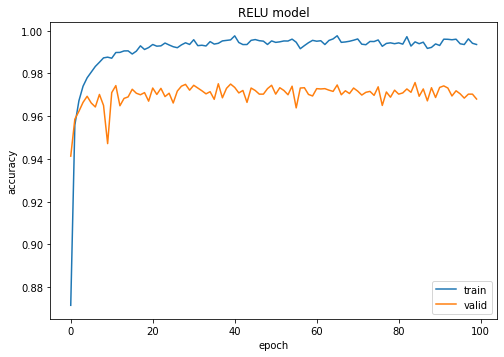

In [79]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(rl_train_acc)
plt.plot(rl_val_acc)
plt.title('RELU model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

LeakyRELU model

In [80]:
model2 = NeuralNetwork(sizes=[784, 128, 64, 10], activation='LeakyReLU')
lrl_runtime, lrl_train_loss, lrl_train_acc, lrl_val_loss, lrl_val_acc = model2.train(X_train, y_train, X_val, y_val, batch_size = 64, epochs=100)

Epoch: 1, Time Spent: 2.77s, Loss:0.0639, Acc: 0.8779 || Val_loss:0.0331, Val_acc: 0.9431
Epoch: 2, Time Spent: 2.72s, Loss:0.0246, Acc: 0.9573 || Val_loss:0.0258, Val_acc: 0.9560
Epoch: 3, Time Spent: 2.75s, Loss:0.0176, Acc: 0.9694 || Val_loss:0.0239, Val_acc: 0.9611
Epoch: 4, Time Spent: 2.69s, Loss:0.0137, Acc: 0.9770 || Val_loss:0.0220, Val_acc: 0.9684
Epoch: 5, Time Spent: 2.73s, Loss:0.0116, Acc: 0.9794 || Val_loss:0.0222, Val_acc: 0.9673
Epoch: 6, Time Spent: 2.68s, Loss:0.0102, Acc: 0.9819 || Val_loss:0.0262, Val_acc: 0.9626
Epoch: 7, Time Spent: 2.69s, Loss:0.0091, Acc: 0.9838 || Val_loss:0.0229, Val_acc: 0.9686
Epoch: 8, Time Spent: 2.72s, Loss:0.0082, Acc: 0.9859 || Val_loss:0.0218, Val_acc: 0.9720
Epoch: 9, Time Spent: 2.70s, Loss:0.0069, Acc: 0.9886 || Val_loss:0.0237, Val_acc: 0.9710
Epoch: 10, Time Spent: 2.71s, Loss:0.0065, Acc: 0.9887 || Val_loss:0.0229, Val_acc: 0.9720
Epoch: 11, Time Spent: 2.72s, Loss:0.0067, Acc: 0.9886 || Val_loss:0.0264, Val_acc: 0.9701
Epoch: 1

In [81]:
lrl_loss, lrl_acc, lrl_recall, lrl_precision, lrl_f1 = model2.evaluate(X_test, y_test)

print("leakyRELU model")
print('loss: ', round(lrl_loss, 4))
print('accuracy: ', round(lrl_acc, 4))
print('f1: ', round(lrl_recall, 4))
print('precision: ', round(rl_precision, 4))
print('recall: ', round(lrl_f1, 4))

leakyRELU model
loss:  0.0436
accuracy:  0.9796
f1:  0.9983
precision:  0.9983
recall:  0.9987


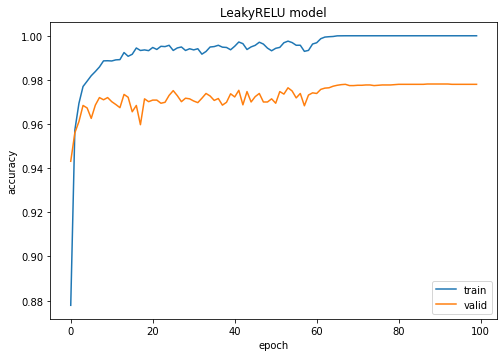

In [82]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(lrl_train_acc)
plt.plot(lrl_val_acc)
plt.title('LeakyRELU model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

Sigmoid model

In [83]:
model3 = NeuralNetwork(sizes=[784, 128, 64, 10], activation='Sigmoid')
s_runtime, s_train_loss, s_train_acc, s_val_loss, s_val_acc = model3.train(X_train, y_train, X_val, y_val, batch_size = 64, epochs=100)

Epoch: 1, Time Spent: 3.41s, Loss:0.1366, Acc: 0.6998 || Val_loss:0.0589, Val_acc: 0.8984
Epoch: 2, Time Spent: 3.36s, Loss:0.0484, Acc: 0.9164 || Val_loss:0.0422, Val_acc: 0.9257
Epoch: 3, Time Spent: 3.40s, Loss:0.0343, Acc: 0.9414 || Val_loss:0.0345, Val_acc: 0.9406
Epoch: 4, Time Spent: 3.39s, Loss:0.0265, Acc: 0.9550 || Val_loss:0.0292, Val_acc: 0.9500
Epoch: 5, Time Spent: 3.38s, Loss:0.0215, Acc: 0.9631 || Val_loss:0.0248, Val_acc: 0.9586
Epoch: 6, Time Spent: 3.34s, Loss:0.0180, Acc: 0.9698 || Val_loss:0.0218, Val_acc: 0.9626
Epoch: 7, Time Spent: 3.37s, Loss:0.0154, Acc: 0.9742 || Val_loss:0.0200, Val_acc: 0.9660
Epoch: 8, Time Spent: 3.41s, Loss:0.0133, Acc: 0.9777 || Val_loss:0.0188, Val_acc: 0.9679
Epoch: 9, Time Spent: 3.39s, Loss:0.0115, Acc: 0.9809 || Val_loss:0.0180, Val_acc: 0.9694
Epoch: 10, Time Spent: 3.46s, Loss:0.0100, Acc: 0.9835 || Val_loss:0.0174, Val_acc: 0.9717
Epoch: 11, Time Spent: 3.38s, Loss:0.0088, Acc: 0.9860 || Val_loss:0.0169, Val_acc: 0.9724
Epoch: 1

In [84]:
s_loss, s_acc, s_recall, s_precision, s_f1 = model3.evaluate(X_test, y_test)

print("Sigmoid model")
print('loss: ', round(s_loss, 4))
print('accuracy: ', round(s_acc, 4))
print('f1: ', round(s_recall, 4))
print('precision: ', round(s_precision, 4))
print('recall: ', round(s_f1, 4))

Sigmoid model
loss:  0.018
accuracy:  0.9796
f1:  0.9983
precision:  0.9986
recall:  0.9984


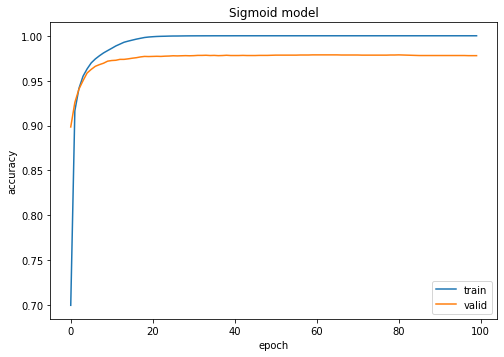

In [85]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(s_train_acc)
plt.plot(s_val_acc)
plt.title('Sigmoid model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

###3.5. Visualizing results

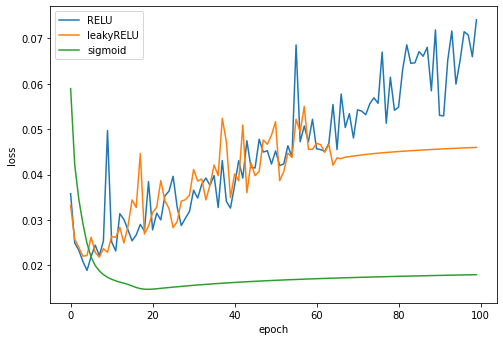

In [86]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(rl_val_loss)
plt.plot(lrl_val_loss)
plt.plot(s_val_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['RELU', 'leakyRELU', 'sigmoid'], loc='upper left')

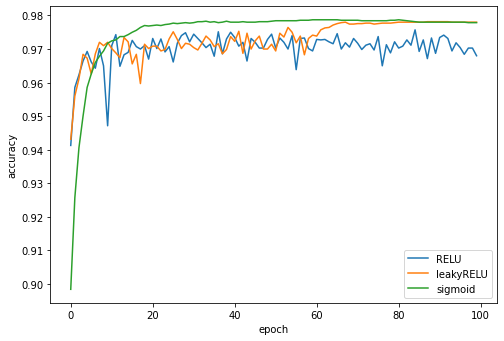

In [87]:
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.plot(rl_val_acc)
plt.plot(lrl_val_acc)
plt.plot(s_val_acc)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['RELU', 'leakyRELU', 'sigmoid'], loc='lower right')

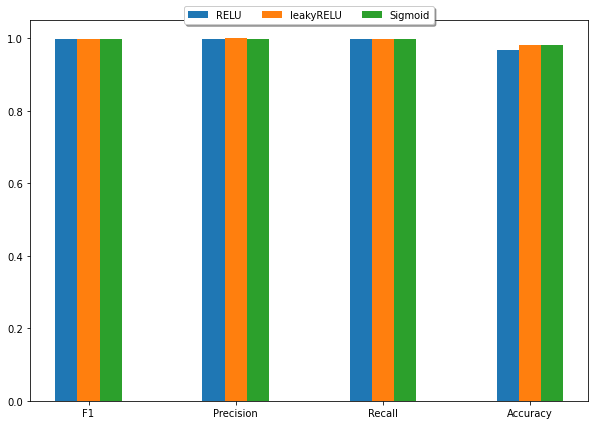

In [88]:
#Trên tập test
N = 4
ind = np.arange(N) 
width = 0.15

score = [[rl_f1, rl_precision, rl_recall, rl_acc],
         [lrl_f1, lrl_precision, lrl_recall,lrl_acc],
         [s_f1, s_precision, s_recall, s_acc]]

fig = plt.figure(figsize=(10, 7))
bar1 = plt.bar(ind, score[0], width)
bar2 = plt.bar(ind+width, score[1], width)
bar3 = plt.bar(ind+width*2, score[2], width)

plt.xticks(ind+width,['F1', 'Precision', 'Recall', 'Accuracy'])
plt.legend( (bar1, bar2, bar3), ('RELU', 'leakyRELU', 'Sigmoid'),
           loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()